### Data OverView

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('../data/raw/bengaluru_house_prices.csv')
print(df.shape)
print(df.info())
print(df.describe())

(13320, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
None
               bath       balcony         price
count  13247.000000  12711.000000  13320.000000
mean       2.692610      1.584376    112.565627
std        1.341458      0.817263    148.971674
min        1.000000      0.000000      8.000000
25%        2.000000      1.000000     50.000000
50%        2.000000      2.000000     72.000000
75%        3.

In [58]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


**Dropping features that are not required to build our model**

In [59]:
df1 = df.drop(['area_type','society','balcony','availability'],axis='columns')

print(df1.shape)
print(df1.info())
print(df1.describe())

(13320, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13319 non-null  object 
 1   size        13304 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13247 non-null  float64
 4   price       13320 non-null  float64
dtypes: float64(2), object(3)
memory usage: 520.4+ KB
None
               bath         price
count  13247.000000  13320.000000
mean       2.692610    112.565627
std        1.341458    148.971674
min        1.000000      8.000000
25%        2.000000     50.000000
50%        2.000000     72.000000
75%        3.000000    120.000000
max       40.000000   3600.000000


### Handling Missing Values

In [60]:
# columns with null values
print(df1.isnull().sum())

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64


In [61]:
#null values are less than 1% of the data, so we can drop them
df2 = df1.dropna()
print(df2.shape)

(13246, 5)


### Feature Engineering

**Adding new feature bhk** 

In [62]:
df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2.bhk.unique()

C:\Users\rohit\AppData\Local\Temp\ipykernel_4512\4049590364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [63]:
summary = pd.DataFrame({
    'dtype': df2.dtypes.astype(str),  
    'unique': df2.nunique()
})

summary

,dtype,unique
location,object,1304
size,object,31
total_sqft,object,2067
bath,float64,19
price,float64,1955
bhk,int64,19


**total_sqft** should be int/float but it is object  

In [64]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

df2[~df2['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


values in total_sqft column are not float, so we need to clean this column

In [65]:
import re
unit_factors = {
    'sq. meter': 10.7639,
    'square meter': 10.7639,
    'sq. yards': 9,
    'sq. yard': 9,
    'acre': 43560,
    'cents': 435.6,
    'cent': 435.6,
    'guntha': 1089,
    'ground': 2400,
    'perch': 272.25,
    'sqft': 1,
    'sq. ft': 1,
    'square feet': 1
}

def convert_to_sqft(x):
    x = str(x).lower().strip()

    # Handle range like "2100 - 2850"
    if '-' in x:
        try:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        except:
            return np.nan

    # Handle known units
    match = re.match(r"([0-9.]+)\s*([a-zA-Z ]+)", x)
    if match:
        val, unit = match.groups()
        val = float(val)
        unit = unit.strip().lower()
        for key in unit_factors:
            if key in unit:
                return val * unit_factors[key]

    # If it's a plain number
    try:
        return float(x)
    except:
        return np.nan

In [66]:
df3 = df2.copy()
df3['total_sqft'] = df3['total_sqft'].apply(convert_to_sqft)

print(df3['total_sqft'].dtypes)
print("Remaining NaNs in total_sqft:", df1['total_sqft'].isna().sum())

float64
Remaining NaNs in total_sqft: 0


In [67]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


Adding New feature **price_per_sqft**

In [68]:
df4 = df3.copy()
df4['price_per_sqft'] = df3['price']*100000/df3['total_sqft']
df4.head()


,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [69]:
print(df4.describe())

         total_sqft          bath         price           bhk  price_per_sqft
count  1.321400e+04  13246.000000  13246.000000  13246.000000    1.321400e+04
mean   1.900864e+03      2.692586    112.389392      2.801902    7.913230e+03
std    1.734092e+04      1.341506    149.076587      1.295758    1.066709e+05
min    1.000000e+00      1.000000      8.000000      1.000000    2.257423e+00
25%    1.100000e+03      2.000000     50.000000      2.000000    4.262963e+03
50%    1.275000e+03      2.000000     72.000000      3.000000    5.433830e+03
75%    1.675000e+03      3.000000    120.000000      3.000000    7.313657e+03
max    1.306800e+06     40.000000   3600.000000     43.000000    1.200000e+07


Examining **location**(categorical value)

In [70]:
df4.location = df4.location.apply(lambda x: x.strip())
location_stats = df4['location'].value_counts(ascending=False)
location_stats

location
Whitefield                              535
Sarjapur  Road                          392
Electronic City                         304
Kanakpura Road                          266
Thanisandra                             236
                                       ... 
Duddanahalli                              1
Doddanakunte                              1
Jogupalya                                 1
Subhash Nagar                             1
Kengeri Satellite Town KHB Apartment      1
Name: count, Length: 1293, dtype: int64

In [71]:
location_stats.values.sum()

np.int64(13246)

In [72]:
print("Number of Different locations:",len(location_stats))
print("Locations with less than or equal to 10 houses:",len(location_stats[location_stats<=10]) )


Number of Different locations: 1293
Locations with less than or equal to 10 houses: 1052


#### Dimensionality Reduction
Tagging locations with less than or equal to 10 data point(rare_location) as "other" to reduce dimensionality while One-Hot-Encoding

In [73]:
len(df4.location.unique())

1293

In [74]:
rare_location = location_stats[location_stats<=10]
rare_location

location
Sector 1 HSR Layout                     10
Basapura                                10
Nagadevanahalli                         10
BTM 1st Stage                           10
Nagappa Reddy Layout                    10
                                        ..
Duddanahalli                             1
Doddanakunte                             1
Jogupalya                                1
Subhash Nagar                            1
Kengeri Satellite Town KHB Apartment     1
Name: count, Length: 1052, dtype: int64

In [75]:
df4.location = df4.location.apply(lambda x: 'other' if x in rare_location else x)
len(df4.location.unique())

242

In [76]:
print(df4.head())
print(df4.describe())

                   location       size  total_sqft  bath   price  bhk  \
0  Electronic City Phase II      2 BHK      1056.0   2.0   39.07    2   
1          Chikka Tirupathi  4 Bedroom      2600.0   5.0  120.00    4   
2               Uttarahalli      3 BHK      1440.0   2.0   62.00    3   
3        Lingadheeranahalli      3 BHK      1521.0   3.0   95.00    3   
4                  Kothanur      2 BHK      1200.0   2.0   51.00    2   

   price_per_sqft  
0     3699.810606  
1     4615.384615  
2     4305.555556  
3     6245.890861  
4     4250.000000  
         total_sqft          bath         price           bhk  price_per_sqft
count  1.321400e+04  13246.000000  13246.000000  13246.000000    1.321400e+04
mean   1.900864e+03      2.692586    112.389392      2.801902    7.913230e+03
std    1.734092e+04      1.341506    149.076587      1.295758    1.066709e+05
min    1.000000e+00      1.000000      8.000000      1.000000    2.257423e+00
25%    1.100000e+03      2.000000     50.000000    

### Outlier Removal

**Interquartile Range (IQR) Method**

In [77]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [78]:
df5 = df4.copy()
for col in ['price', 'total_sqft', 'bath', 'bhk']:
    df5 = remove_outliers_iqr(df5, col)

print(df5.shape)

(10807, 7)


 **Z-Score Method**

In [79]:
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores <= threshold]

In [80]:
df6 = df5.copy()
for col in ['price', 'total_sqft', 'bath', 'bhk']:
    df6 = remove_outliers_zscore(df6, col)

print(df6.shape)

(10640, 7)


#### Removing Outlier using Business-Aware Logics

We assume a minimum of 300 sqft per BHK. Properties with less than 300 sqft per BHK (e.g., a 2 BHK in 400 sqft) are considered outliers and will be removed.

In [81]:
df7 = df6[~(df6.total_sqft/df6.bhk<300)]
print(df7.shape)

(10386, 7)


It’s uncommon for a property to have more bathrooms than bedrooms plus two.
Remove properties with more bathrooms than bedrooms plus two (bath > bhk + 2)

In [82]:
df8 = df7[df7['bath'] <= df7['bhk'] + 2]
print(df8.shape)
# no change in shape, so either no such cases or they were already removed in previous steps

(10386, 7)


**Location-Specific PPSF Rules**


Certain areas (e.g., Whitefield, Koramangala, Indiranagar) are known for higher property values. We can apply a higher PPSF threshold for these luxury locations.

In [83]:
# Define luxury locations that can have higher PPSF
luxury_locations = ['Whitefield', 'Koramangala', 'Indiranagar']

# Assign a higher PPSF threshold for luxury locations and a standard threshold for others
df8.loc[df8['location'].isin(luxury_locations), 'max_ppsf'] = 30000  # Luxury max
df8.loc[~df8['location'].isin(luxury_locations), 'max_ppsf'] = 20000 # Standard max

# Remove properties with PPSF above their location-specific threshold
df8 = df8[df8['price_per_sqft'] <= df8['max_ppsf']]

# Remove the helper column after filtering
df8 = df8.drop(columns=['max_ppsf'])

print(df8.shape)

(10380, 7)


### Save Cleaned Data

In [84]:
df_cleaned = df8[['location', 'total_sqft', 'bath', 'bhk', 'price_per_sqft', 'price']].dropna()
df_cleaned.to_csv('../data/processed/cleaned_bangalore_house_data.csv', index=False)
print("Cleaned data saved to '../data/processed/cleaned_bangalore_house_data.csv'")

Cleaned data saved to '../data/processed/cleaned_bangalore_house_data.csv'


### Visualize Cleaned Data

In [85]:
# Set plot style
sns.set(style='whitegrid')

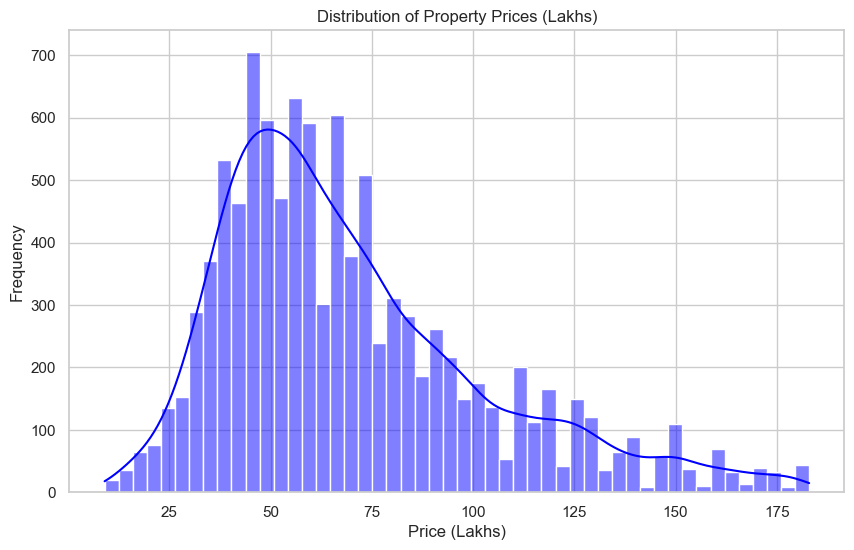

In [86]:
# Plot 1: Distribution of Price
plt.figure(figsize=(10, 6))
sns.histplot(df8['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Property Prices (Lakhs)')
plt.xlabel('Price (Lakhs)')
plt.ylabel('Frequency')
plt.show()

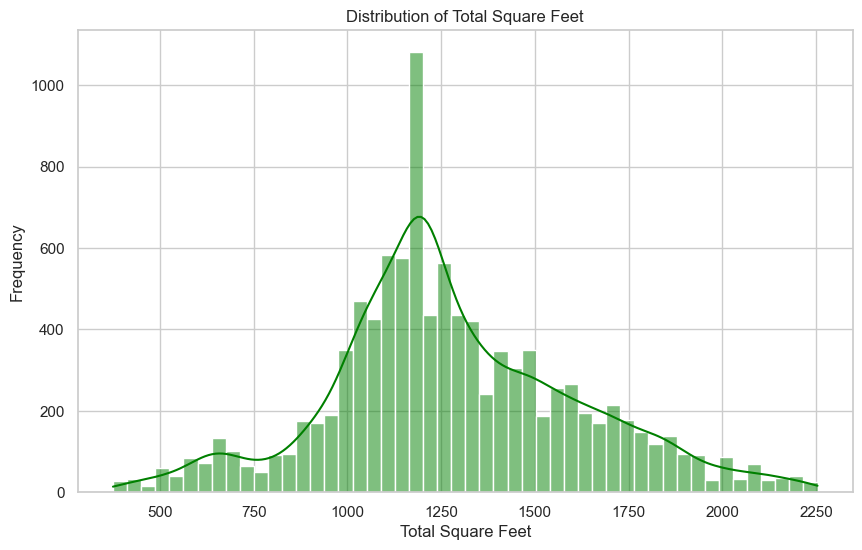

In [87]:
# Plot 2: Distribution of Total Square Feet
plt.figure(figsize=(10, 6))
sns.histplot(df8['total_sqft'], bins=50, kde=True, color='green')
plt.title('Distribution of Total Square Feet')
plt.xlabel('Total Square Feet')
plt.ylabel('Frequency')
plt.show()

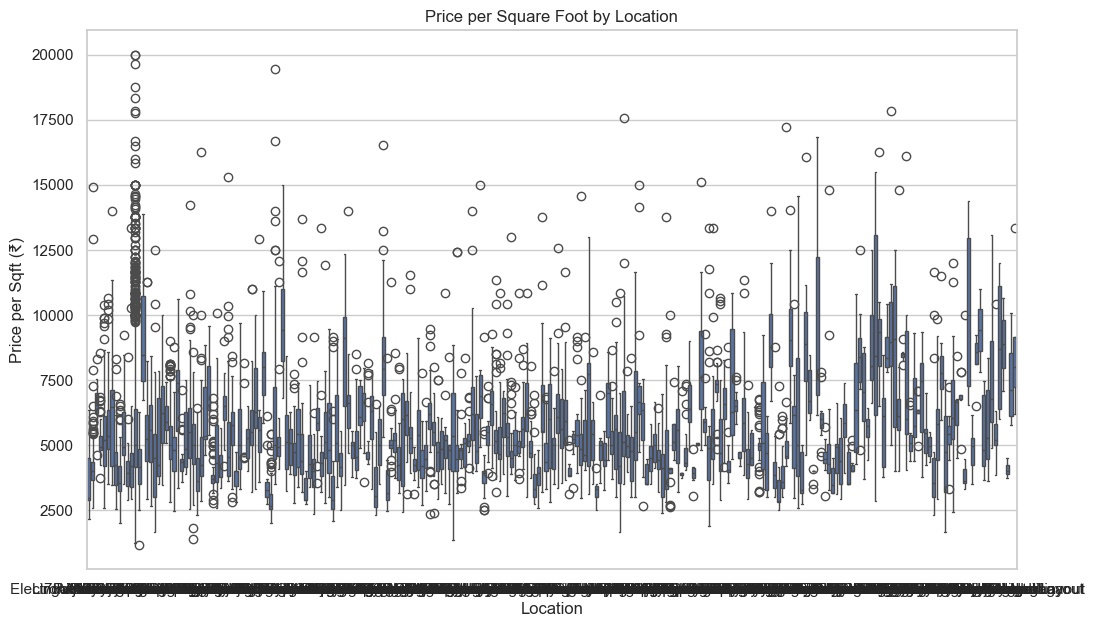

In [88]:
# Plot 3: Price per Square Foot by Location (Boxplot)
plt.figure(figsize=(12, 7))
sns.boxplot(x='location', y='price_per_sqft', data=df8)
plt.title('Price per Square Foot by Location')
plt.xlabel('Location')
plt.ylabel('Price per Sqft (₹)')
plt.show()